In [2]:
import sys
import os
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

# Get the absolute path to the src directory
sys.path.append(os.path.abspath("../src"))
# Now you can import preprocessor
from preprocessor import LLMTIMEPreprocessor
from generate_predictions import PredictionPipeline, TrajectoryDataset


In [11]:
# 📌 Step 3: Load the Lotka-Volterra Data
file_path = "../lotka_volterra_data.h5"

with h5py.File(file_path, "r") as f:
    trajectories = f["trajectories"][:]  # Shape: (1000, 100, 2)
    time_points = f["time"][:]  # Shape: (100,)

# Convert to Pandas DataFrame for visualization
num_samples = 1000  # Reduce to 10 samples for easier viewing
data_dict = {
    "Time": np.tile(time_points, num_samples),
    "Prey Population": trajectories[:num_samples, :, 0].flatten(),
    "Predator Population": trajectories[:num_samples, :, 1].flatten(),
    "Sample ID": np.repeat(range(num_samples), len(time_points)),
}

df = pd.DataFrame(data_dict)

In [12]:
df.shape

(100000, 4)

In [13]:
df.head()

,Time,Prey Population,Predator Population,Sample ID
0,0.000000,0.949917,1.040624,0
1,2.020202,0.740551,0.779542,0
2,4.040404,0.682246,0.564390,0
3,6.060606,0.716674,0.407644,0
4,8.080808,0.824511,0.300283,0


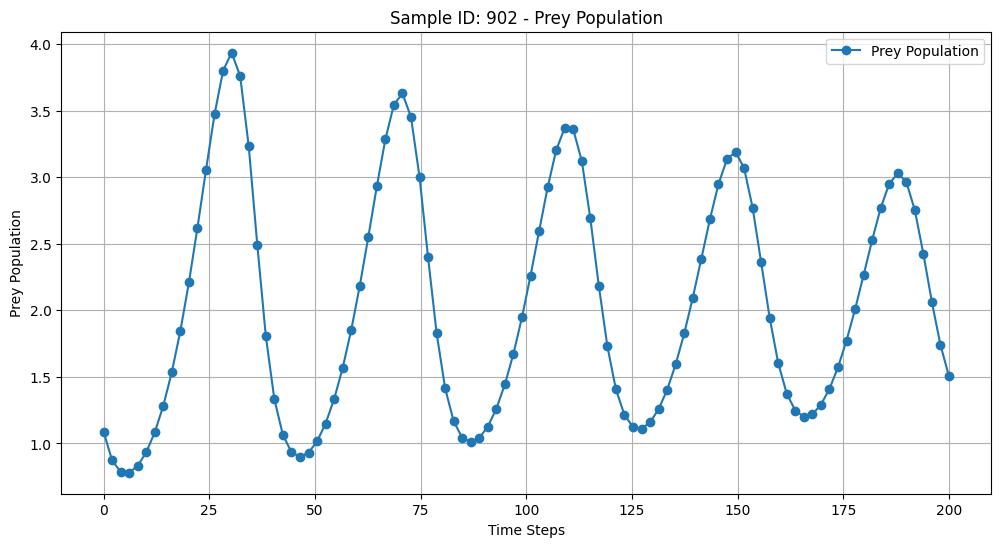

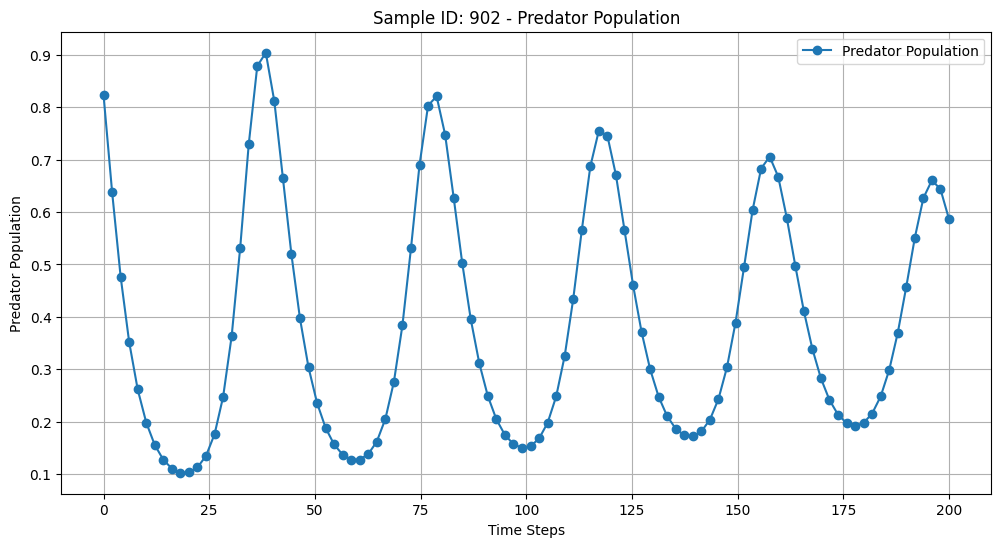

In [16]:
import matplotlib.pyplot as plt

# Extract the data for Sample ID = 4
sample_id = 902
sample_data = df[df['Sample ID'] == sample_id]

# Extract time, prey population, and predator population
time = sample_data['Time'].values
prey_population = sample_data['Prey Population'].values
predator_population = sample_data['Predator Population'].values

# Plot the true values for prey population
plt.figure(figsize=(12, 6))
plt.plot(time, prey_population, label='Prey Population', marker='o')
plt.title(f'Sample ID: {sample_id} - Prey Population')
plt.xlabel('Time Steps')
plt.ylabel('Prey Population')
plt.legend()
plt.grid(True)
plt.show()

# Plot the true values for predator population
plt.figure(figsize=(12, 6))
plt.plot(time, predator_population, label='Predator Population', marker='o')
plt.title(f'Sample ID: {sample_id} - Predator Population')
plt.xlabel('Time Steps')
plt.ylabel('Predator Population')
plt.legend()
plt.grid(True)
plt.show()

/Users/raunaqrai/miniconda_x86_64/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


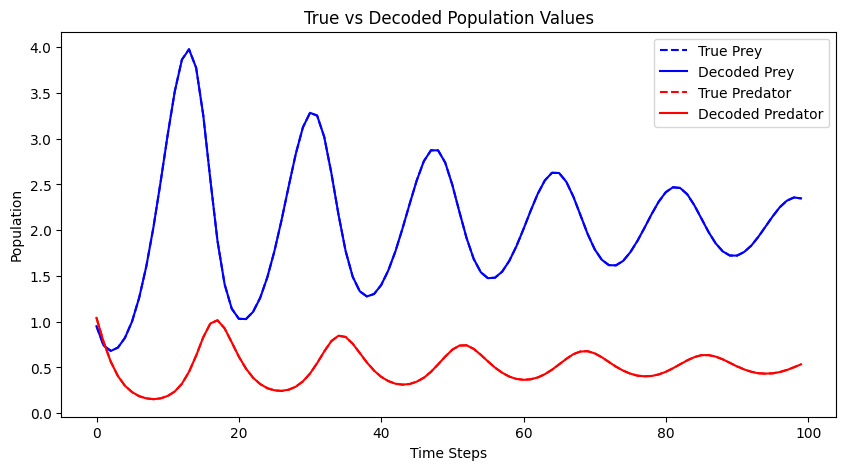


📊 Evaluation Metrics:
   MSE: 0.0000
   MAE: 0.0009
   R² Score: 1.0000


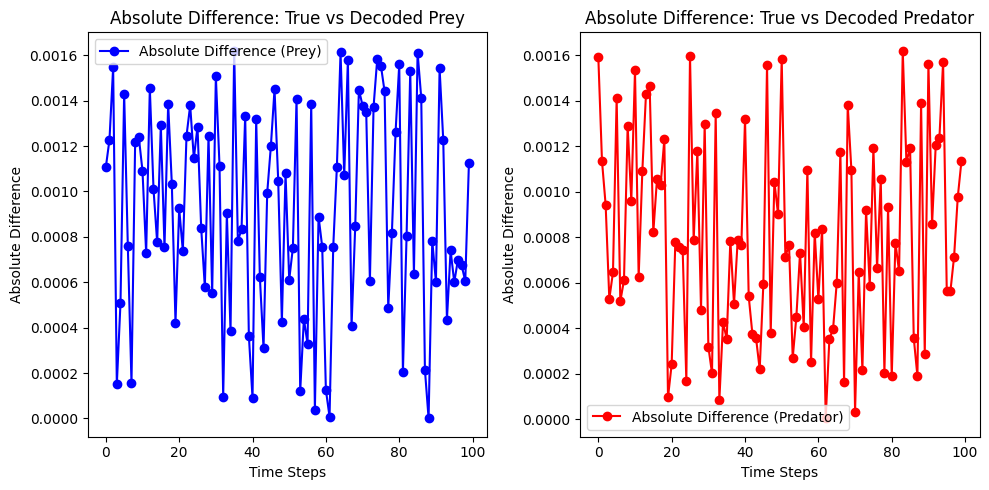

Mean Squared Error (Prey): 0.000001
Mean Squared Error (Predator): 0.000001


In [9]:
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
import os
import h5py
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

sys.path.append(os.path.abspath("../src"))

from load_qwen import load_qwen_model  # Ensure load_qwen is correctly implemented
from preprocessor import LLMTIMEPreprocessor  # Ensure LLMTIMEPreprocessor is correctly implemented

# Load the model and tokenizer
model, tokenizer = load_qwen_model()

# Set the model to evaluation mode
model.eval()

# Initialize preprocessor
preprocessor = LLMTIMEPreprocessor()

# Load the true data from the HDF5 file
file_path = "../lotka_volterra_data.h5"
with h5py.File(file_path, "r") as f:
    trajectories = f["trajectories"][:]
    time_points = f["time"][:]

# Select a sample index and number of steps
sample_index = 0
num_steps = 100

# Extract prey and predator data for the selected sample
prey = trajectories[sample_index, :num_steps, 0]
predator = trajectories[sample_index, :num_steps, 1]

# Preprocess data (tokenize the input)
formatted_text, tokenized_seq, scale_factor = preprocessor.preprocess_sample(prey, predator, num_steps)

# Decode tokens back to text
decoded_text = tokenizer.decode(tokenized_seq[0], skip_special_tokens=True)

# Parse the decoded text back into numerical values
decoded_pairs = [list(map(float, pair.split(','))) for pair in decoded_text.split(';') if ',' in pair]
decoded_prey, decoded_predator = zip(*decoded_pairs) if decoded_pairs else ([], [])

# Scale back to original values
decoded_prey = np.array(decoded_prey) * scale_factor
decoded_predator = np.array(decoded_predator) * scale_factor

# Plot the true vs decoded values
plt.figure(figsize=(10, 5))
plt.plot(prey, label="True Prey", linestyle='dashed', color='blue')
plt.plot(decoded_prey, label="Decoded Prey", linestyle='solid', color='blue')

plt.plot(predator, label="True Predator", linestyle='dashed', color='red')
plt.plot(decoded_predator, label="Decoded Predator", linestyle='solid', color='red')

plt.xlabel("Time Steps")
plt.ylabel("Population")
plt.title("True vs Decoded Population Values")
plt.legend()
plt.show()

# Calculate evaluation metrics
true_values = np.concatenate((prey, predator))
decoded_values = np.concatenate((decoded_prey, decoded_predator))

mse = mean_squared_error(true_values, decoded_values)
mae = mean_absolute_error(true_values, decoded_values)
r2 = r2_score(true_values, decoded_values)

print("\n📊 Evaluation Metrics:")
print(f"   MSE: {mse:.4f}")
print(f"   MAE: {mae:.4f}")
print(f"   R² Score: {r2:.4f}")

# Plot the absolute differences
abs_diff_prey = np.abs(prey - decoded_prey)
abs_diff_predator = np.abs(predator - decoded_predator)

plt.figure(figsize=(10, 5))

# Prey absolute difference plot
plt.subplot(1, 2, 1)
plt.plot(abs_diff_prey, label="Absolute Difference (Prey)", color='blue', marker='o')
plt.xlabel("Time Steps")
plt.ylabel("Absolute Difference")
plt.title("Absolute Difference: True vs Decoded Prey")
plt.legend()

# Predator absolute difference plot
plt.subplot(1, 2, 2)
plt.plot(abs_diff_predator, label="Absolute Difference (Predator)", color='red', marker='o')
plt.xlabel("Time Steps")
plt.ylabel("Absolute Difference")
plt.title("Absolute Difference: True vs Decoded Predator")
plt.legend()

plt.tight_layout()
plt.show()

mse_prey = mean_squared_error(prey, decoded_prey)
mse_predator = mean_squared_error(predator, decoded_predator)

# Print MSE values
print(f"Mean Squared Error (Prey): {mse_prey:.6f}")
print(f"Mean Squared Error (Predator): {mse_predator:.6f}")

/Users/raunaqrai/miniconda_x86_64/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Need to generate 25 timesteps
Processing Sample ID: 0
Using scale factor: 0.326
Generated 24 timesteps out of 25 needed
Now generated 26 timesteps out of 25 needed
Processing Sample ID: 1
Using scale factor: 0.363
Generated 24 timesteps out of 25 needed
Now generated 26 timesteps out of 25 needed
Processing Sample ID: 2
Using scale factor: 0.340
Generated 24 timesteps out of 25 needed
Now generated 26 timesteps out of 25 needed
Processing Sample ID: 3
Using scale factor: 0.250
Generated 24 timesteps out of 25 needed
Now generated 26 timesteps out of 25 needed
Processing Sample ID: 4
Using scale factor: 0.716
Generated 24 timesteps out of 25 needed
Now generated 26 timesteps out of 25 needed
Processing Sample ID: 5
Using scale factor: 0.195
Generated 24 timesteps out of 25 needed
Now generated 26 timesteps out of 25 needed
Processing Sample ID: 6
Using scale factor: 0.408
Generated 24 timesteps out of 25 needed
Now generated 26 timesteps out of 25 needed
Processing Sample ID: 7
Using sc

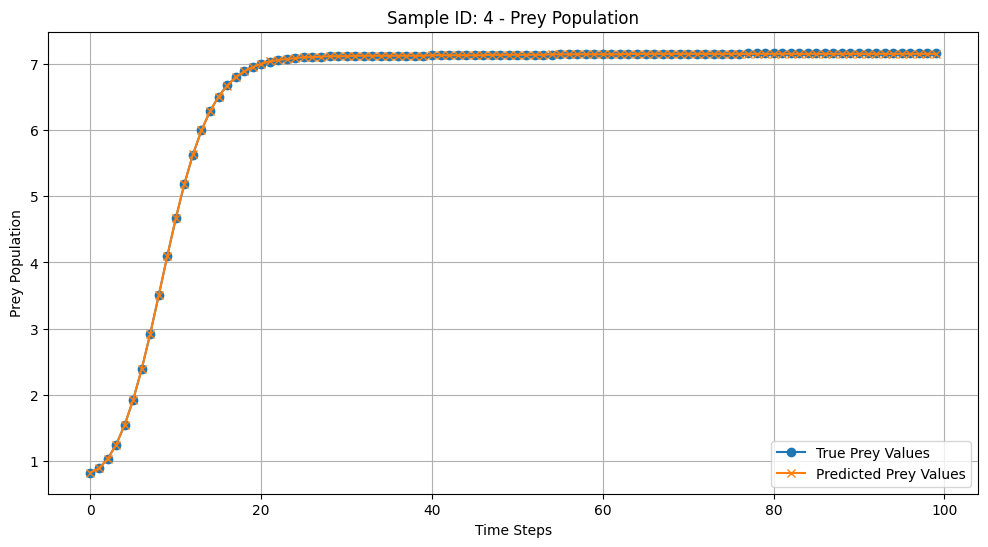

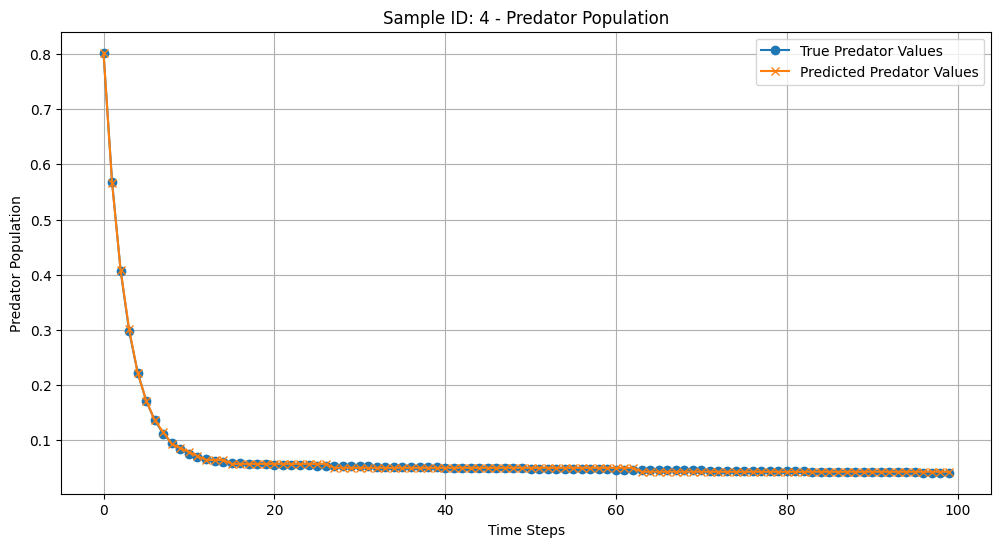

In [6]:
import sys
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import h5py

# Add the path to the preprocessor.py and load_qwen.py files
sys.path.append(os.path.abspath("../src"))

# Import the necessary modules
from preprocessor import LLMTIMEPreprocessor
from load_qwen import load_qwen_model

# Load the Qwen2.5 model and tokenizer
model, tokenizer = load_qwen_model()

# Select device (GPU if available, else MPS for Mac, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

# Set the model to evaluation mode
model.eval()

# Instantiate the preprocessor
preprocessor = LLMTIMEPreprocessor()

def baseline_model_testing(data, test_fraction=0.75):
    """
    Evaluates the model's ability to predict missing timesteps in a sequence for each Sample ID.

    Args:
        data (DataFrame): The dataset containing time-series data.
        test_fraction (float): Fraction of the sequence to use as input.

    Returns:
        dict: A dictionary with Sample ID as keys and predictions as values.
    """
    predictions = {}
    sample_ids = data['Sample ID'].unique()

    input_timesteps = int(test_fraction * 100)
    output_timesteps = 100 - input_timesteps  # Number of timesteps to generate

    print(f"Need to generate {output_timesteps} timesteps")

    for sample_id in sample_ids:
        print(f'Processing Sample ID: {sample_id}')
        sample_data = data[data['Sample ID'] == sample_id]
        prey = sample_data['Prey Population'].values
        predator = sample_data['Predator Population'].values

        # Preprocess the input data
        input_text, tokenized_input, scale_factor = preprocessor.preprocess_sample(prey, predator, input_timesteps)
        tokens = tokenized_input.to(device)

        # First generation attempt
        token_preds = model.generate(
            tokens, 
            max_new_tokens=int(output_timesteps * 10)
        )

        # Count timesteps generated
        semicolons = (token_preds[0] == tokenizer.convert_tokens_to_ids(';')).nonzero(as_tuple=True)[0]
        timesteps_generated = len(semicolons) - input_timesteps
        print(f'Generated {timesteps_generated} timesteps out of {output_timesteps} needed')

        # Continue generating if needed
        while len(semicolons) < 100:
            timesteps_needed = 100 - len(semicolons)
            token_preds = model.generate(
                token_preds, 
                max_new_tokens=int(timesteps_needed * 10 + 10)  # Generate missing timesteps
            )

            semicolons = (token_preds[0] == tokenizer.convert_tokens_to_ids(';')).nonzero(as_tuple=True)[0]
            timesteps_generated = len(semicolons) - input_timesteps
            print(f'Now generated {timesteps_generated} timesteps out of {output_timesteps} needed')

            # Stop if the sequence gets too long
            if len(token_preds[0]) > 2000: 
                print("Warning: Reached maximum token length, stopping generation")
                break

        # Truncate unnecessary tokens
        if len(semicolons) >= 100:
            end_idx = semicolons[99].item() 
            tokens_1d = token_preds[0][:end_idx]
        else:
            tokens_1d = token_preds[0]  # Use all tokens if not enough semicolons found

        decoded_preds = tokenizer.decode(tokens_1d, skip_special_tokens=True)

        # Parse the decoded text back into numerical values
        decoded_pairs = [list(map(float, pair.split(','))) for pair in decoded_preds.split(';') if ',' in pair]
        decoded_prey, decoded_predator = zip(*decoded_pairs) if decoded_pairs else ([], [])

        # Scale back to original values
        decoded_prey = np.array(decoded_prey) * scale_factor
        decoded_predator = np.array(decoded_predator) * scale_factor

        predictions[sample_id] = {
            "prey": decoded_prey,
            "predator": decoded_predator
        }

    return predictions

# Example usage
predictions = baseline_model_testing(df, test_fraction=0.75)

# Function to plot the predictions and original series
def plot_predictions(predictions, original_series, sample_id):
    """
    Plots the predictions against the original series for a specific Sample ID.

    Args:
        predictions (dict): A dictionary with Sample ID as keys and predictions as values.
        original_series (numpy array): The original series for the specified Sample ID.
        sample_id (int): The Sample ID to plot.
    """
    pred_prey = predictions[sample_id]["prey"]
    pred_predator = predictions[sample_id]["predator"]
    original_data = original_series

    # Extract the true values
    true_prey = original_data[:, 0]
    true_predator = original_data[:, 1]

    # Plot the true and predicted values for prey
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(true_prey)), true_prey, label='True Prey Values', marker='o')
    plt.plot(range(len(pred_prey)), pred_prey, label='Predicted Prey Values', marker='x')
    plt.title(f'Sample ID: {sample_id} - Prey Population')
    plt.xlabel('Time Steps')
    plt.ylabel('Prey Population')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot the true and predicted values for predator
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(true_predator)), true_predator, label='True Predator Values', marker='o')
    plt.plot(range(len(pred_predator)), pred_predator, label='Predicted Predator Values', marker='x')
    plt.title(f'Sample ID: {sample_id} - Predator Population')
    plt.xlabel('Time Steps')
    plt.ylabel('Predator Population')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming original_series is a dictionary with Sample ID as keys and original series as values
original_series = {sample_id: df[df['Sample ID'] == sample_id][['Prey Population', 'Predator Population']].values for sample_id in df['Sample ID'].unique()}

# Example usage for Sample ID = 4
sample_id = 4
plot_predictions(predictions, original_series[sample_id], sample_id)

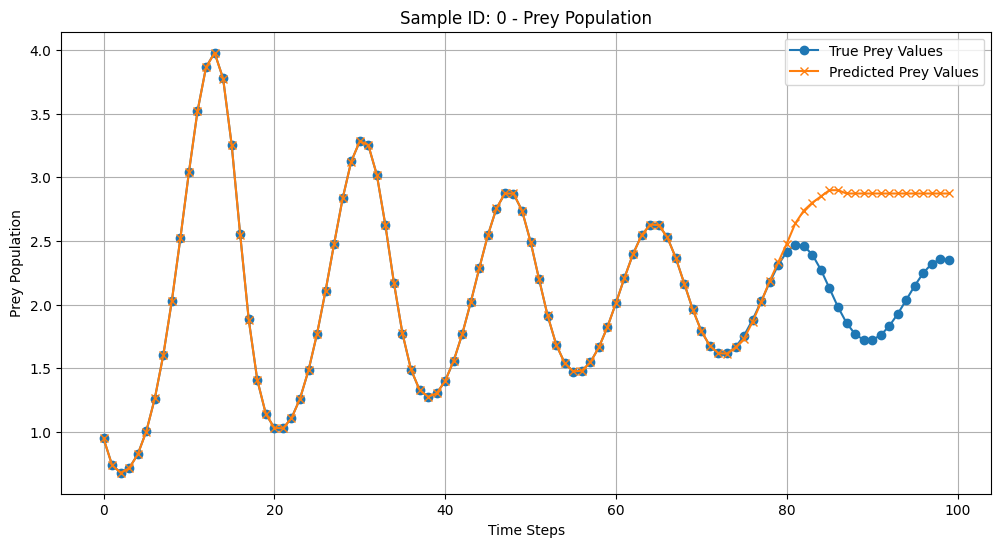

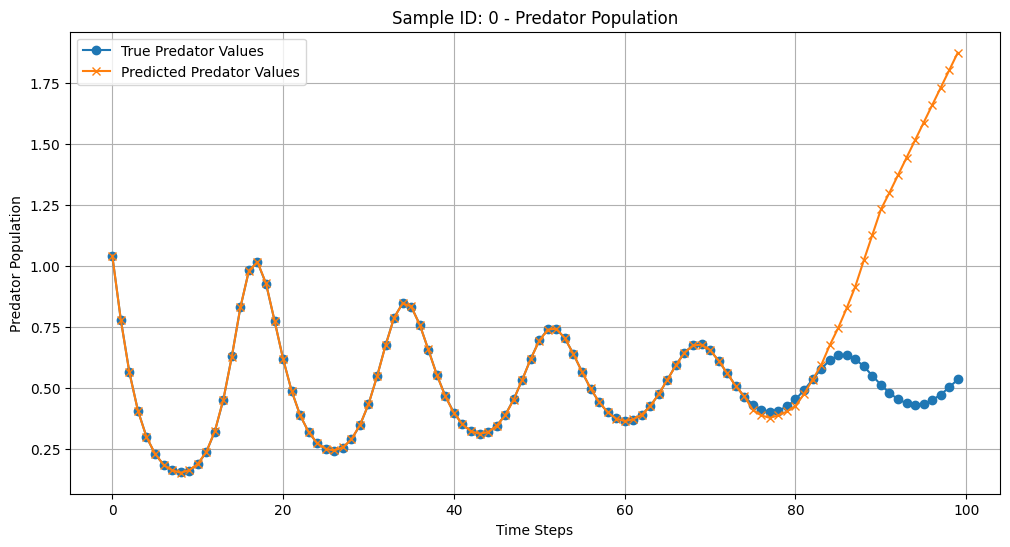

In [8]:
sample_id = 0
plot_predictions(predictions, original_series[sample_id], sample_id)

/Users/raunaqrai/miniconda_x86_64/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.



🔹 Test 1 of 5
Generated 24 timesteps out of 25 needed
Now generated 26 timesteps out of 25 needed

🔹 Test 2 of 5
Generated 24 timesteps out of 25 needed
Now generated 26 timesteps out of 25 needed

🔹 Test 3 of 5
Generated 24 timesteps out of 25 needed
Now generated 26 timesteps out of 25 needed

🔹 Test 4 of 5
Generated 24 timesteps out of 25 needed
Now generated 26 timesteps out of 25 needed

🔹 Test 5 of 5
Generated 24 timesteps out of 25 needed
Now generated 26 timesteps out of 25 needed


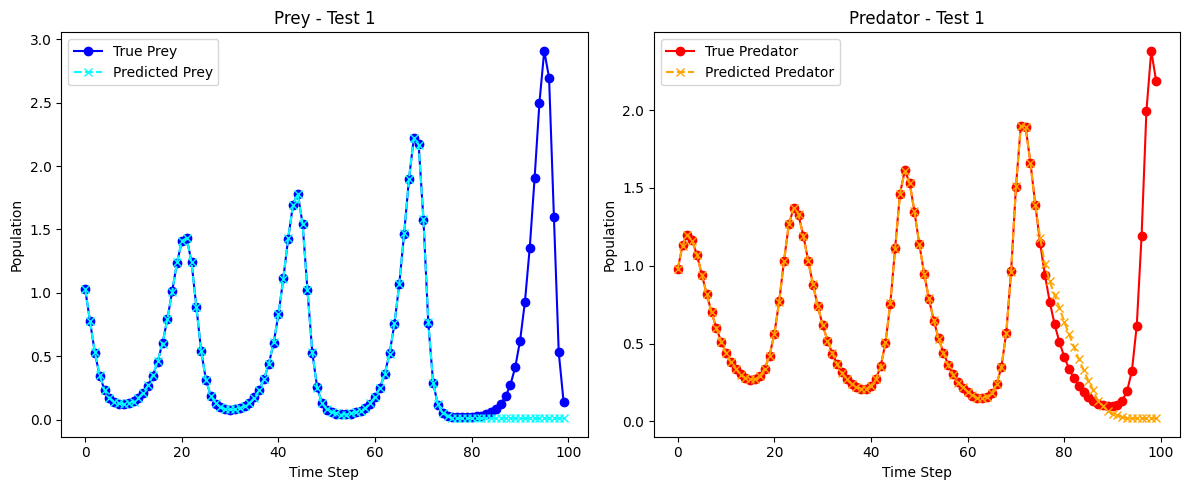

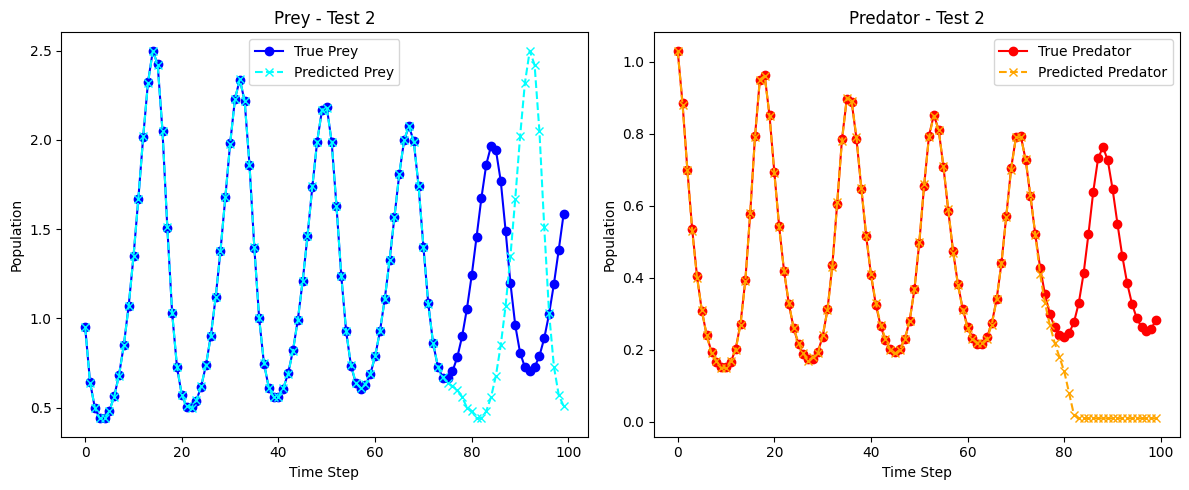

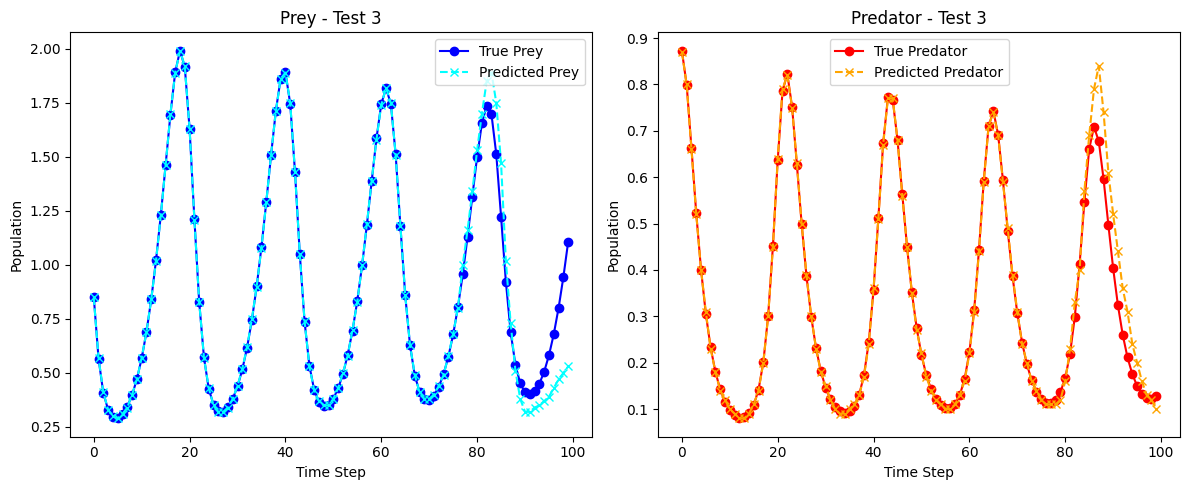

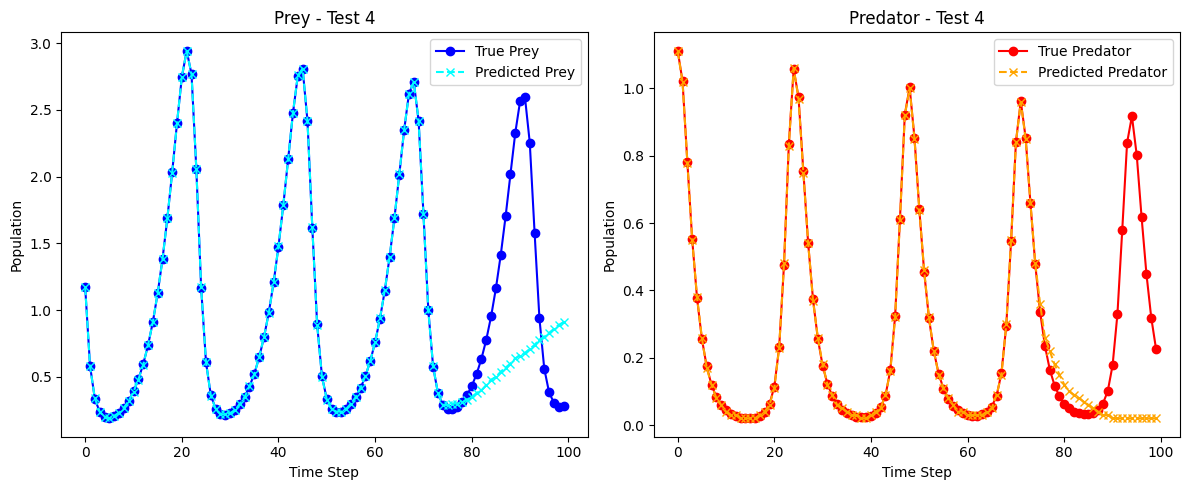

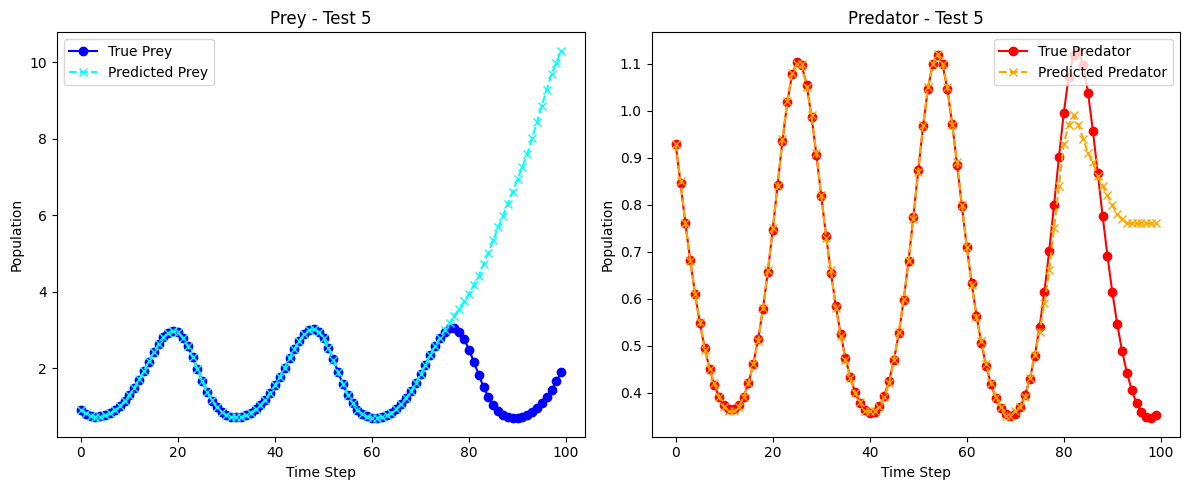

In [2]:
# Step 1: Load your dataset
dataset = TrajectoryDataset("../lotka_volterra_data.h5")

# Step 2: Create a prediction pipeline
pipeline = PredictionPipeline(dataset)

# Step 3: Generate predictions
predictions, original_series = pipeline.predict(num_tests=5)

# Step 4: Plot the results
pipeline.plot_predictions(predictions, original_series)


/Users/raunaqrai/miniconda_x86_64/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


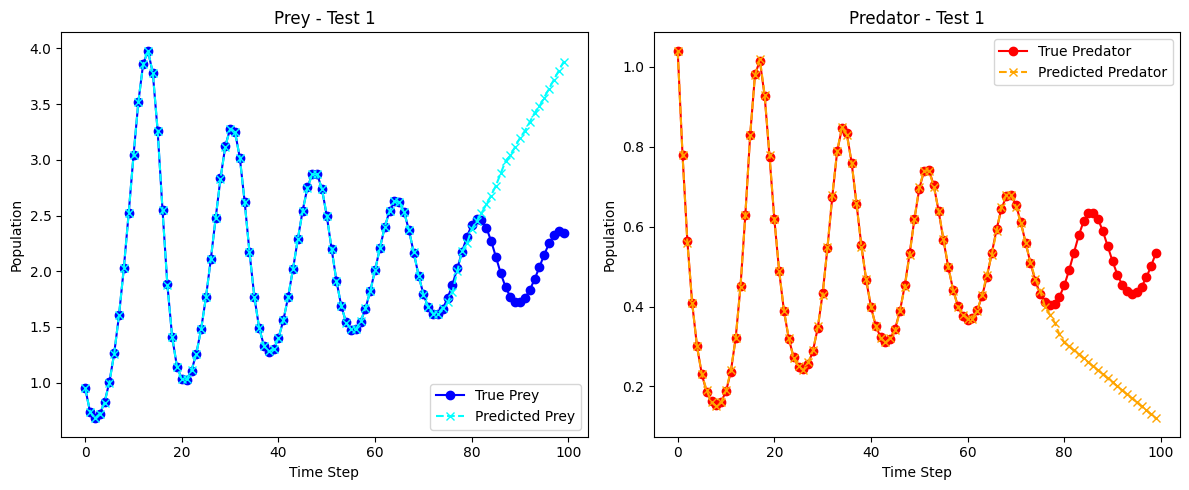

In [2]:
from generate_predictions import TrajectoryDataset, PredictionPipeline

dataset = TrajectoryDataset("../lotka_volterra_data.h5")
pipeline = PredictionPipeline(dataset)

predictions, original_series = pipeline.predict_by_index(0)
pipeline.plot_predictions(predictions, original_series)
